<a href="https://colab.research.google.com/github/uday-routhu/mocktest/blob/master/Belt_Exam_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Uday Routhu

# Problem:
An airline company would like to know more about their customers and how to please them.  They have provided some information about 20,000 customers as well as the results of a satisfaction survey.  The data is available [here](https://docs.google.com/spreadsheets/d/e/2PACX-1vSAUJiI10coRG2ZgJ_H6PJkPuIfr-tYVRRX9wtJvAyI_SHnAjvbd7RZHifP6XoeSS9HPNp38IfzPzIY/pub?output=csv).

They would like you to:

1. Segment the customers into groups and describe those groups, what they have in common and how they differ.

2. Model the data to see if over-all customer satisfaction can be predicted by information about their flights and answers to the survey other than overall satisfaction.

# Clustering instructions:
The airline company would like you to segment the customers and create an analytical report on the clusters describing each group and describing how they are different.

1. Load the dataset.
2. Explore the data.
3. Prepare the data for modeling.
4. Use a KMeans model to cluster the students into an optimal number of clusters.
  1. Use an elbow plot and silhouette score to find the optimal number of clusters.
  2. There must be between 2 and 10 clusters.
5. Analyze and report on the clusters.
  1. Describe each cluster.
  2. How are the clusters different?
  3. Create 2 report quality explanatory visualizations showing important differences between the clusters.
  4. Interpret and explain each visualization.

# Modeling Instructions:
The airline would also like to know how well overall satisfaction can be predicted from information about passengers and satisfaction with specific parts of their experience. Your target will be the 'satisfied' column.

1. Use random_state = 42 for your train_test_split.
2. Apply PCA to reduce the number of features to a more reasonable number.
  1. Report the how many fewer columns are present after PCA.
  2. Report the amount of variance retained after PCA.
3. Do not leak data.
4. Use a deep learning model to predict whether customers will report that they were satisfied.
  1. Create 3 different versions of a sequential model.
    1. Each new model should be an iteration on the previous model.
    2. Justify in writing why you changed what you did for each new model.
      1. For example, why did you add layers, regularization, nodes, etc.
  2. Use some form of regularization with at least one model.
  3. Evaluate each model with appropriate metrics.
5. Choose a final model and justify your choice.
6. Explain in writing how well your model will solve the business problem.

### Imports


In [29]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, \
classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# new libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout


# This is used to overcome an issue with setting up tensorflow in M1/M1
# Suspect tensorflow-macos not very fit with GPU, use CPU only with
tf.config.set_visible_devices([], 'GPU')

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
def eval_regression(model, X, y, name='model'):
    """Returns a dataframe with regression metrics.
    optional name variable can be used to name each model and/or dataset used
    for clarity"""
    score_df = pd.DataFrame(index=[name])
    preds = model.predict(X)
    score_df.loc[name,'MAE'] = mean_absolute_error(y, preds)
    score_df.loc[name,'RMSE'] = np.sqrt(mean_squared_error(y, preds))
    score_df.loc[name,'R2'] = r2_score(y, preds)
    return score_df

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load the dataset.

In [5]:
csv_file_path = "/content/drive/MyDrive/CodingDojo/03-AdvancedML/Week12/Data/option_A_clustering_df - option_A_clustering_df.csv"
df= pd.read_csv(csv_file_path)

In [10]:
df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,220,0,6,0,2,1,1965,-122.196399,47.336118
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,340,0,4,1,0,1,1945,-122.361913,47.509874
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.156684,47.437557
3,659000,660,0,540,0,1820,620,620,0,0,...,0,100,0,3,1,0,2,2016,-122.370252,47.565146
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,320,0,3,0,0,2,1967,-122.184194,47.730389


# Explore the data.

In [6]:
df.duplicated().sum()

29

- There are 29 duplicate records are there

In [7]:
# Drop all duplicate records
df.drop_duplicates(inplace=True)

In [43]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

SalePrice             0
SqFt1stFloor          0
SqFtHalfFloor         0
SqFt2ndFloor          0
SqFtUpperFloor        0
SqFtTotLiving         0
SqFtTotBasement       0
SqFtFinBasement       0
SqFtGarageBasement    0
SqFtGarageAttached    0
DaylightBasement      0
SqFtOpenPorch         0
SqFtEnclosedPorch     0
SqFtDeck              0
BrickStone            0
Bedrooms              0
BathHalfCount         0
Bath3qtrCount         0
BathFullCount         0
YrBuilt               0
Longitude             0
Latitude              0
dtype: int64

- Never use fillna() to impute values prior to Scaling, as it would cause data leakage.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4915 entries, 0 to 4943
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SalePrice           4915 non-null   int64  
 1   SqFt1stFloor        4915 non-null   int64  
 2   SqFtHalfFloor       4915 non-null   int64  
 3   SqFt2ndFloor        4915 non-null   int64  
 4   SqFtUpperFloor      4915 non-null   int64  
 5   SqFtTotLiving       4915 non-null   int64  
 6   SqFtTotBasement     4915 non-null   int64  
 7   SqFtFinBasement     4915 non-null   int64  
 8   SqFtGarageBasement  4915 non-null   int64  
 9   SqFtGarageAttached  4915 non-null   int64  
 10  DaylightBasement    4915 non-null   int64  
 11  SqFtOpenPorch       4915 non-null   int64  
 12  SqFtEnclosedPorch   4915 non-null   int64  
 13  SqFtDeck            4915 non-null   int64  
 14  BrickStone          4915 non-null   int64  
 15  Bedrooms            4915 non-null   int64  
 16  BathHa

In [7]:
df.describe()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
count,4.944000e+03,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,...,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000,4944.000000
mean,6.643497e+05,1175.502832,51.758495,349.306837,26.994134,1935.205097,595.065939,334.273463,102.417071,170.282160,...,8.271238,148.908576,4.415858,3.375607,0.387743,0.628236,1.319579,1972.183455,-122.271891,47.572471
std,2.978080e+05,446.398643,174.464172,544.632918,115.331907,764.888792,567.175862,422.825946,187.119944,239.635895,...,37.449815,201.636086,18.643753,0.947061,0.506022,0.651598,0.609963,32.905503,0.086519,0.127187
min,6.000000e+04,260.000000,0.000000,0.000000,0.000000,300.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,-122.526072,47.213547
25%,4.500000e+05,880.000000,0.000000,0.000000,0.000000,1390.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,1952.000000,-122.346573,47.488749
50%,6.305500e+05,1170.000000,0.000000,0.000000,0.000000,1770.000000,560.000000,110.000000,0.000000,0.000000,...,0.000000,50.000000,0.000000,3.000000,0.000000,1.000000,1.000000,1967.000000,-122.291976,47.576939
75%,7.886125e+05,1450.000000,0.000000,580.000000,0.000000,2360.000000,1070.000000,570.000000,190.000000,400.000000,...,0.000000,257.000000,0.000000,4.000000,1.000000,1.000000,2.000000,2016.000000,-122.192528,47.681099
max,1.998000e+06,3600.000000,2000.000000,3010.000000,1220.000000,6695.000000,3070.000000,2620.000000,1090.000000,1830.000000,...,620.000000,1940.000000,100.000000,8.000000,3.000000,4.000000,5.000000,2019.000000,-122.090088,47.777422


# Clustering

## Prepare the dataset for modeling

#### Scaling and Modeling

In [15]:
# Scale the data
imputer = SimpleImputer(strategy='median')
X_scaled = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
X_scaled.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000.0,1590.0,0.0,0.0,0.0,3180.0,1590.0,1590.0,0.0,600.0,...,0.0,220.0,0.0,6.0,0.0,2.0,1.0,1965.0,-122.196399,47.336118
1,474250.0,1390.0,0.0,0.0,0.0,2200.0,810.0,810.0,0.0,0.0,...,0.0,340.0,0.0,4.0,1.0,0.0,1.0,1945.0,-122.361913,47.509874
2,667950.0,1010.0,0.0,1515.0,0.0,2525.0,0.0,0.0,0.0,400.0,...,0.0,0.0,0.0,4.0,1.0,0.0,2.0,2019.0,-122.156684,47.437557
3,659000.0,660.0,0.0,540.0,0.0,1820.0,620.0,620.0,0.0,0.0,...,0.0,100.0,0.0,3.0,1.0,0.0,2.0,2016.0,-122.370252,47.565146
4,656500.0,2310.0,0.0,0.0,0.0,2310.0,0.0,0.0,0.0,440.0,...,0.0,320.0,0.0,3.0,0.0,0.0,2.0,1967.0,-122.184194,47.730389


## Use a KMeans model to cluster the customers into an optimal number of clusters

1. Use an elbow plot and silhouette score to find the optimal number of clusters.
2. There must be between 2 and 10 clusters.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

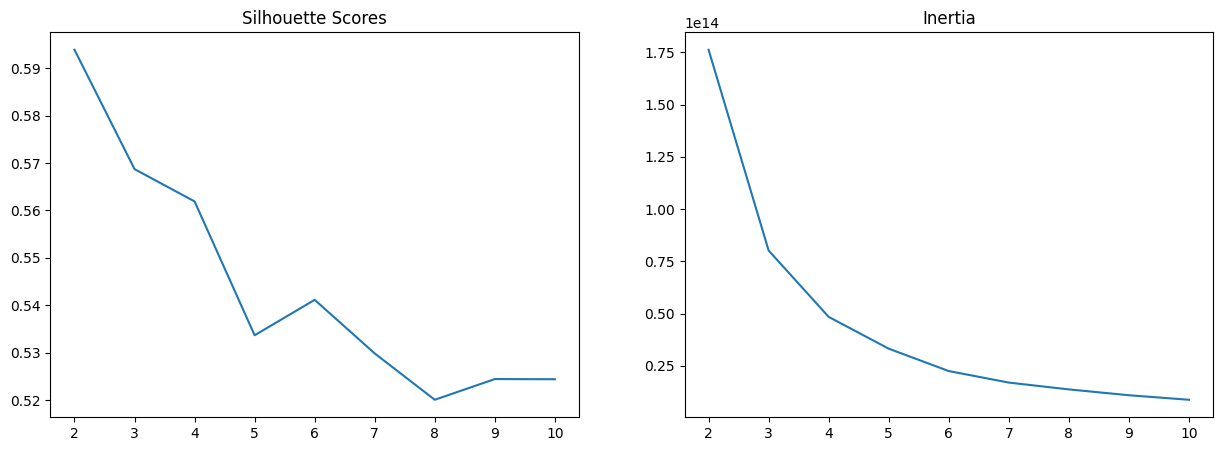

In [21]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_scaled)
  sils.append(silhouette_score(X_scaled, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

We have a couple of choices of clusters numbers here. The best silhouette score is 2, though 5 and 7 also have good scores.  The elbows in the inertia plot seem to be at 6 and 7.  I'm going to choose to use 2 clusters, but 5, 6 or 7 might also be good choices.  

In [23]:
# Refit KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans.labels_
df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude,cluster
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,220,0,6,0,2,1,1965,-122.196399,47.336118,0
1,474250,1390,0,0,0,2200,810,810,0,0,...,340,0,4,1,0,1,1945,-122.361913,47.509874,0
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,4,1,0,2,2019,-122.156684,47.437557,0
3,659000,660,0,540,0,1820,620,620,0,0,...,100,0,3,1,0,2,2016,-122.370252,47.565146,0
4,656500,2310,0,0,0,2310,0,0,0,440,...,320,0,3,0,0,2,1967,-122.184194,47.730389,0


#### 3.Analyzing the cluster

In [34]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,0,5.407562e+05,1126.016505,41.401362,272.878701,25.951271,1765.694786,553.174745,302.147236,101.951795,...,8.347655,135.809012,3.633482,3.256484,0.355253,0.580299,1.252554,1971.641341,-122.277040,47.556792
1,1,1.094872e+06,1363.561020,88.664845,606.634791,28.517304,2534.520036,747.684882,449.136612,103.661202,...,7.850638,193.097450,7.252277,3.806922,0.500911,0.790528,1.555556,1972.869763,-122.252795,47.626249


#### Visualizing the Clusters

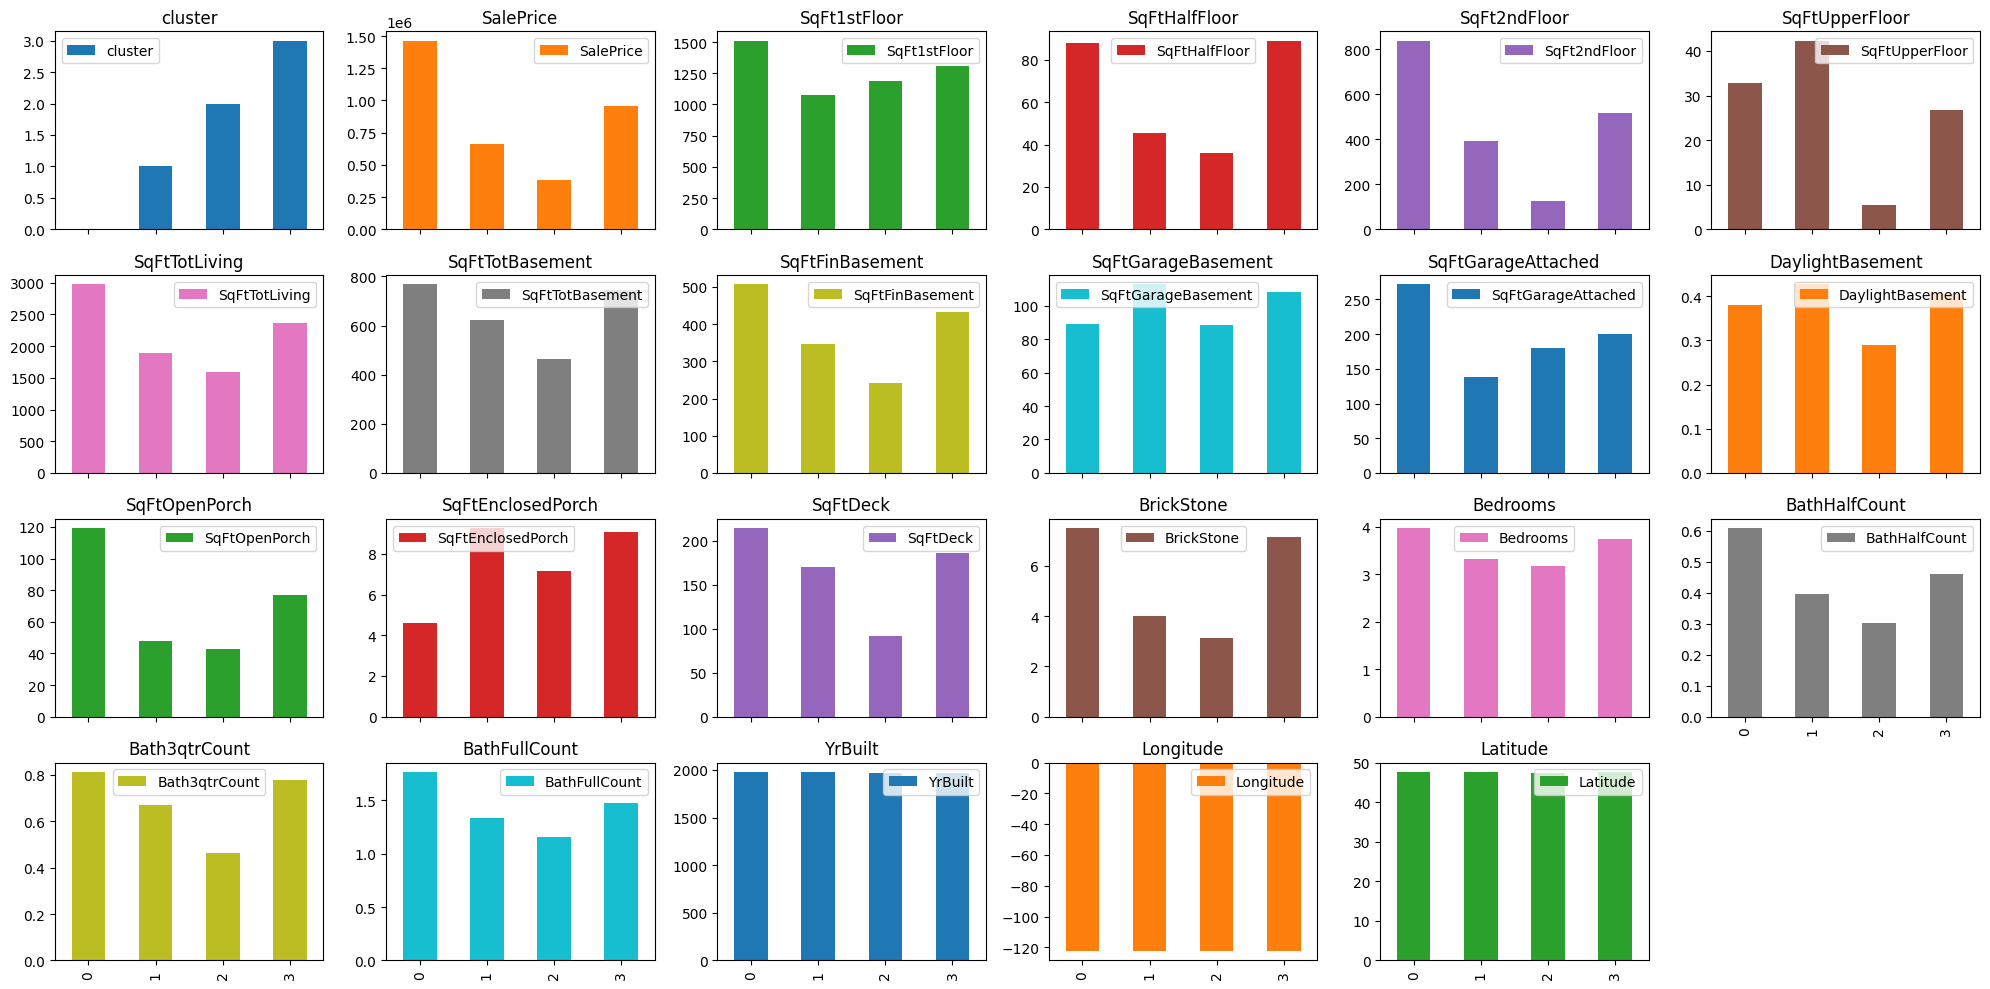

In [19]:
# Visualize means values of each column
#cluster_groups.plot(subplots=True, kind='bar', figsize=(20,10),layout =(3,4))
cluster_groups.plot(subplots=True, kind='bar', figsize=(20, 10), layout=(4, 6))
plt.tight_layout()

### How are the clusters different?

cluster 0:
 - Properties in Cluster 0 have, on average, a lower sale price compared to Cluster 1. This suggests that Cluster 0 may represent properties that are more affordable or less expensive.
 - The average total living area (SqFtTotLiving) in Cluster 0 is smaller compared to Cluster 1. Properties in this cluster tend to have smaller living spaces.
 - Cluster 0 has, on average, fewer bedrooms compared to Cluster 1. This indicates that properties in this cluster may be smaller or have fewer bedrooms.
 - he average number of full bathrooms (BathFullCount) in Cluster 0 is relatively lower compared to Cluster 1, suggesting that properties in this cluster may have fewer full bathrooms.

cluster 1:
   - Properties in Cluster 1 have, on average, a higher sale price compared to Cluster 0. This suggests that Cluster 1 may represent more expensive properties.
   - SqFtTotLiving: Cluster 1 has a significantly larger average total living area (SqFtTotLiving) compared to Cluster 0. Properties in this cluster tend to have larger living spaces.
   - Bedrooms: Cluster 1 has, on average, more bedrooms compared to Cluster 0. This indicates that properties in this cluster may be larger or have more bedrooms.
   - BathFullCount: The average number of full bathrooms (BathFullCount) in Cluster 1 is higher compared to Cluster 0, suggesting that properties in this cluster may have more full bathrooms.

# Create 2 report quality explanatory visualizations showing important differences between the clusters.

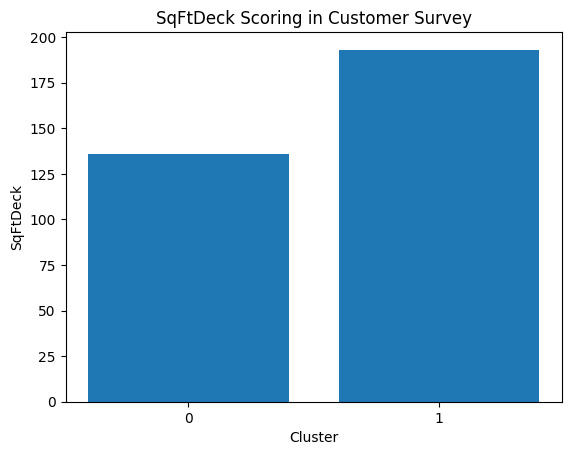

In [32]:
plt.bar(cluster_groups.index,cluster_groups['SqFtDeck'] )
plt.title('SqFtDeck Scoring in Customer Survey')
plt.ylabel('SqFtDeck')
plt.xlabel('Cluster')
plt.xticks(cluster_groups.index);

Cluster 1 happens to have a higher stastifaction score compared to Cluster 0. This probably means they have a larger sqft and this typically happens to be a feature in economy plus or business class.

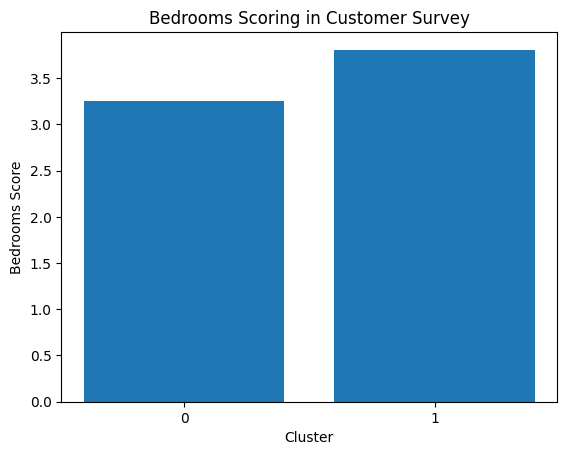

In [33]:
plt.bar(cluster_groups.index,cluster_groups['Bedrooms'] )
plt.title('Bedrooms Scoring in Customer Survey')
plt.ylabel('Bedrooms Score')
plt.xlabel('Cluster')
plt.xticks(cluster_groups.index);

Cluster 1 happens to have a higher stastifaction score compared to Cluster 0. This probably means they have more bedrooms and this typically happens to be a feature in economy plus or business class.

In [20]:
df.loc[df['cluster']==0].index

Int64Index([  16,   34,   48,   54,   58,   75,  103,  112,  157,  170,
            ...
            4734, 4756, 4761, 4770, 4858, 4890, 4891, 4901, 4908, 4943],
           dtype='int64', length=289)

#### Recomendations

Cluster 0:
 - Cluster 0 may represent properties that are more affordable on average. Consider targeting buyers or renters who are looking for budget-friendly options.
 - Given that Cluster 0 has smaller living spaces and fewer bedrooms, focus on marketing these properties to individuals or small families who prioritize lower costs and don't need extensive space.
 - If properties in Cluster 0 have unique features, such as brick or stone elements, consider emphasizing these features in your marketing materials to make these properties stand out.

CLuster 1:
 - Cluster 1 may represent higher-end properties with larger living spaces and more bedrooms. Consider targeting affluent buyers or renters looking for spacious and upscale homes.
 - Highlight the larger deck, open porch, and any other unique features or amenities that Cluster 1 properties offer to attract buyers or renters who value outdoor living spaces.
 - If you own or are involved with properties in Cluster 1, consider investing in further upgrades or renovations to enhance the luxury appeal and overall value of these properties.

### Modeling

#### Split Data

In [8]:
# Save X data
X = df.drop(columns='SalePrice')
# Encode our target
y = df['SalePrice']

In [9]:
# Split the data (random_state=42 for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [77]:
# Initialize PCA, specifying the desired explained variance ratio (e.g., 0.95)
pca = PCA(n_components=0.95)

# Fit and transform PCA on training data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
# Standardize the features
scaler = StandardScaler()
transformer = make_pipeline(scaler, PCA(n_components=0.95))

In [13]:
# Standardize the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [15]:
# Print the dimensions after PCA
print("Shape of X_train after PCA:", X_train_pca.shape)
print("Shape of X_test after PCA:", X_test_pca.shape)

Shape of X_train after PCA: (3686, 16)
Shape of X_test after PCA: (1229, 16)


# First Model1

In [20]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# use all features as input using input_dim
input_dim = X_train_pca.shape[1]

# Instantiate your sequential model
reg_model1 = Sequential()

# Add first hidden layer
reg_model1.add(Dense(3, activation= 'relu', input_dim = input_dim, name ='h1'))
reg_model1.add(Dense(6, activation='relu', name='h2'))

# Add output layer with 1 node

reg_model1.add(Dense(1, activation = 'linear', name = 'output'))


# Check summary of network
reg_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 3)                 51        
                                                                 
 h2 (Dense)                  (None, 6)                 24        
                                                                 
 output (Dense)              (None, 1)                 7         
                                                                 
Total params: 82 (328.00 Byte)
Trainable params: 82 (328.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
from tensorflow.keras.metrics import RootMeanSquaredError

In [21]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')

reg_model1.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

In [50]:
# Fit your model
history = reg_model1.fit(X_train_pca, y_train,
                        validation_data = (X_test_pca, y_test),
                        epochs = 100,verbose=False)

Epoch 1/100
116/116 [==============================] - 1s 4ms/step - loss: 473786286080.0000 - mae: 624931.8125 - rmse: 688321.3750 - val_loss: 494755315712.0000 - val_mae: 632380.6250 - val_rmse: 703388.4375
Epoch 2/100
116/116 [==============================] - 0s 3ms/step - loss: 472553652224.0000 - mae: 624005.8125 - rmse: 687425.3750 - val_loss: 493526515712.0000 - val_mae: 631451.3750 - val_rmse: 702514.4375
Epoch 3/100
116/116 [==============================] - 0s 3ms/step - loss: 471305846784.0000 - mae: 623068.5000 - rmse: 686517.1875 - val_loss: 492286967808.0000 - val_mae: 630513.8125 - val_rmse: 701631.6250
Epoch 4/100
116/116 [==============================] - 0s 3ms/step - loss: 470037889024.0000 - mae: 622118.5625 - rmse: 685593.0625 - val_loss: 491026939904.0000 - val_mae: 629559.3750 - val_rmse: 700733.1250
Epoch 5/100
116/116 [==============================] - 0s 3ms/step - loss: 468755972096.0000 - mae: 621150.5000 - rmse: 684657.5625 - val_loss: 489757868032.0000 - 

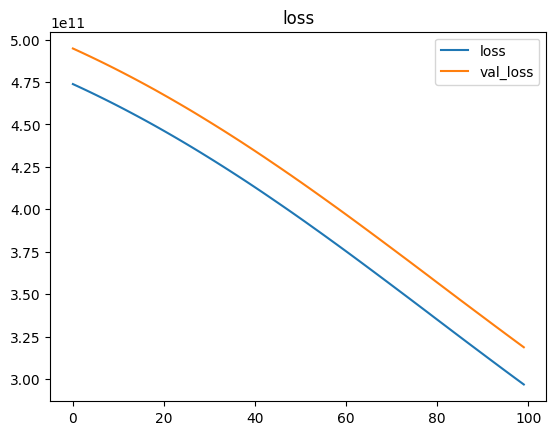

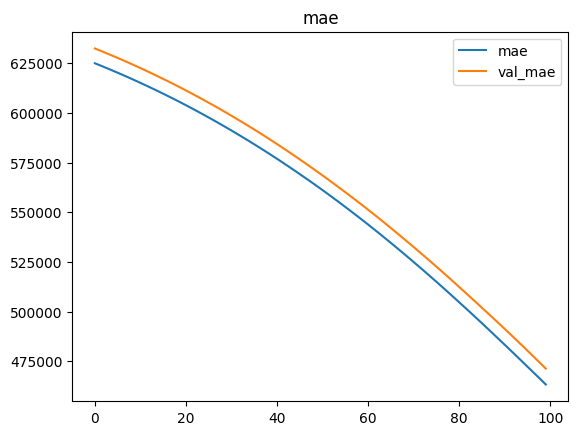

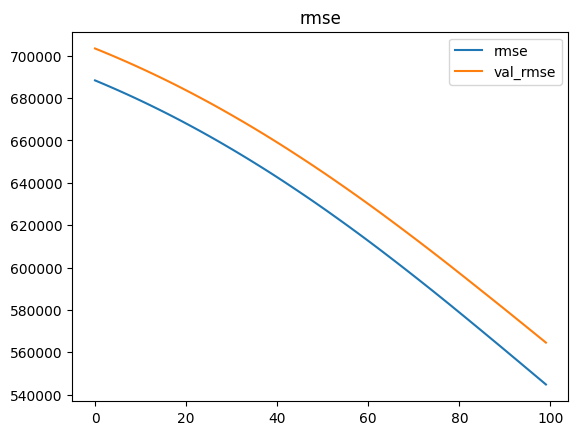

In [51]:
# Apply the custom function to see how your model is doing
plot_history(history)

In [30]:
# Evalution

train_scores = eval_regression(reg_model1,
                         X_train_pca,
                         y_train,
                         name='reg_model1 Train')
test_scores = eval_regression(reg_model1,
                                       X_test_pca,
                                       y_test,
                                       name='reg_model1 test')
scores = pd.concat([train_scores, test_scores])
scores

39/39 [==============================] - 0s 4ms/step


,MAE,RMSE,R2
reg_model1 Train,625379.381101,688753.501128,-4.485105
reg_model1 test,633286.182606,704241.349581,-4.112044


# Second Model

In [35]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# use all features as input using input_dim
input_dim = X_train_pca.shape[1]

# Instantiate your sequential model
reg_model2 = Sequential()

# Add hidden layer
reg_model2.add(Dense(3, activation= 'relu', input_dim = input_dim, name ='h1'))
reg_model2.add(Dense(6, activation='relu', name='h2'))
reg_model2.add(Dense(10, activation='relu', name='h3'))
# Add output layer with 1 node

reg_model2.add(Dense(1, activation = 'linear', name = 'output'))

# Check summary of network
reg_model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 3)                 51        
                                                                 
 h2 (Dense)                  (None, 6)                 24        
                                                                 
 h3 (Dense)                  (None, 10)                70        
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 156 (624.00 Byte)
Trainable params: 156 (624.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')
reg_model2.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

In [37]:
# Fit your model
history = reg_model2.fit(X_train_pca, y_train,
                        validation_data = (X_test_pca, y_test),
                        epochs = 100)

Epoch 1/100
116/116 [==============================] - 1s 4ms/step - loss: 525510148096.0000 - mae: 662589.3125 - rmse: 724920.8125 - val_loss: 546462466048.0000 - val_mae: 670406.8750 - val_rmse: 739231.0000
Epoch 2/100
116/116 [==============================] - 0s 3ms/step - loss: 525508280320.0000 - mae: 662588.3750 - rmse: 724919.5000 - val_loss: 546458959872.0000 - val_mae: 670404.1875 - val_rmse: 739228.6250
Epoch 3/100
116/116 [==============================] - 0s 3ms/step - loss: 525500121088.0000 - mae: 662581.8125 - rmse: 724913.8750 - val_loss: 546443165696.0000 - val_mae: 670392.6875 - val_rmse: 739217.9375
Epoch 4/100
116/116 [==============================] - 0s 3ms/step - loss: 525470826496.0000 - mae: 662560.8750 - rmse: 724893.6875 - val_loss: 546395619328.0000 - val_mae: 670358.1875 - val_rmse: 739185.8125
Epoch 5/100
116/116 [==============================] - 0s 3ms/step - loss: 525396606976.0000 - mae: 662507.5000 - rmse: 724842.5000 - val_loss: 546285879296.0000 - 

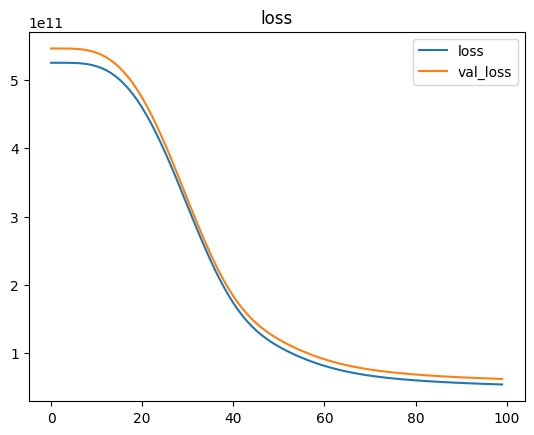

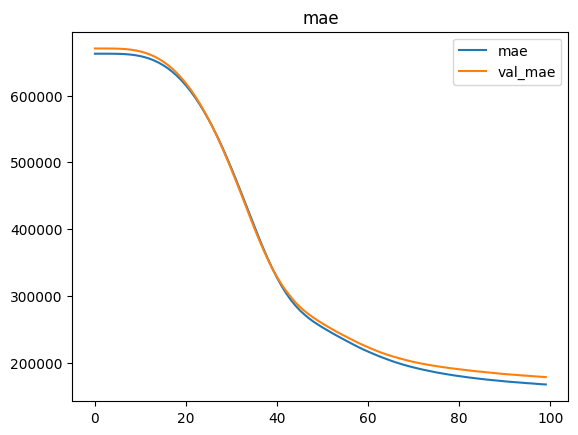

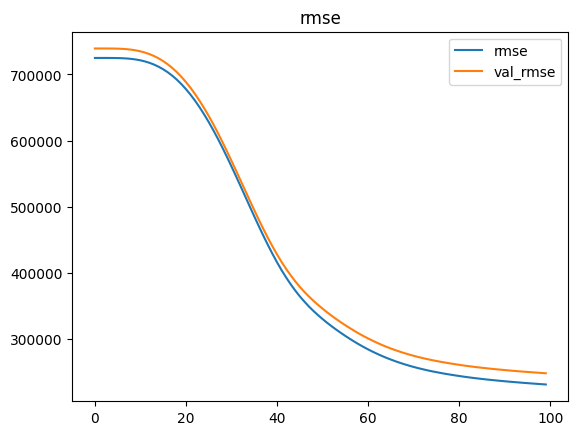

In [38]:
# Apply the custom function to see how your model is doing
plot_history(history)

In [39]:
#Evalution
train_scores = eval_regression(reg_model2,
                         X_train_pca,
                         y_train,
                         name='reg_model2 Train')
test_scores = eval_regression(reg_model2,
                                       X_test_pca,
                                       y_test,
                                       name='reg_model2 test')
scores = pd.concat([scores, train_scores, test_scores])
scores

39/39 [==============================] - 0s 2ms/step


,MAE,RMSE,R2
reg_model1 Train,625379.381101,688753.501128,-4.485105
reg_model1 test,633286.182606,704241.349581,-4.112044
reg_model2 Train,167038.397124,231274.985973,0.381536
reg_model2 test,178440.382884,248537.524259,0.363299


# Third Model

In [40]:
# Instantiate your sequential model
reg_model3 = Sequential()

# Add hidden layers
reg_model3.add(Dense(100, activation= 'relu', input_dim = input_dim, name ='h1'))
reg_model3.add(Dense(60, activation='relu', name='h2'))
reg_model3.add(Dense(100, activation='relu', name='h3'))
reg_model3.add(Dense(10, activation='relu', name='h4'))
reg_model3.add(Dense(10, activation='relu', name='h5'))

# Add output layer with 1 node
reg_model3.add(Dense(1, activation='linear', name ='output'))

# Check summary of network
reg_model3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 100)               1700      
                                                                 
 h2 (Dense)                  (None, 60)                6060      
                                                                 
 h3 (Dense)                  (None, 100)               6100      
                                                                 
 h4 (Dense)                  (None, 10)                1010      
                                                                 
 h5 (Dense)                  (None, 10)                110       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 14991 (58.56 KB)
Trainable params: 14991

In [41]:
# Compile your model.
rmse = RootMeanSquaredError(name='rmse')
reg_model3.compile(optimizer= 'adam', loss = 'mse', metrics= ['mae', rmse])

In [42]:
# Fit your model
history = reg_model3.fit(X_train_pca, y_train,
                        validation_data = (X_test_pca, y_test),
                        epochs = 200)

Epoch 1/200
116/116 [==============================] - 4s 9ms/step - loss: 525350109184.0000 - mae: 662476.6250 - rmse: 724810.3750 - val_loss: 545076969472.0000 - val_mae: 669452.6250 - val_rmse: 738293.3125
Epoch 2/200
116/116 [==============================] - 1s 6ms/step - loss: 483840360448.0000 - mae: 632777.4375 - rmse: 695586.3125 - val_loss: 374578053120.0000 - val_mae: 544664.7500 - val_rmse: 612027.8125
Epoch 3/200
116/116 [==============================] - 1s 10ms/step - loss: 138855120896.0000 - mae: 282498.7500 - rmse: 372632.6875 - val_loss: 60174221312.0000 - val_mae: 172203.5000 - val_rmse: 245304.3438
Epoch 4/200
116/116 [==============================] - 1s 8ms/step - loss: 51738120192.0000 - mae: 159707.4219 - rmse: 227460.1562 - val_loss: 56938934272.0000 - val_mae: 165700.8750 - val_rmse: 238618.8125
Epoch 5/200
116/116 [==============================] - 1s 8ms/step - loss: 49547431936.0000 - mae: 155919.3906 - rmse: 222592.5312 - val_loss: 55699058688.0000 - val_

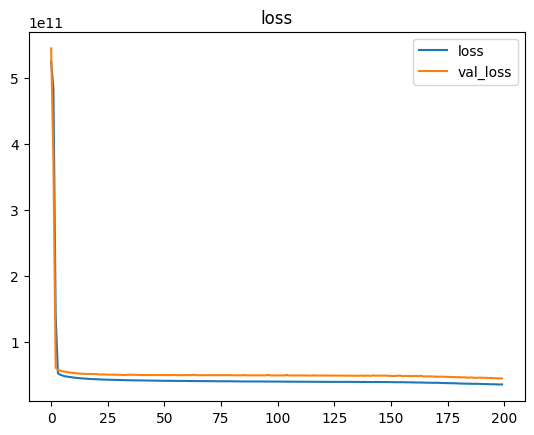

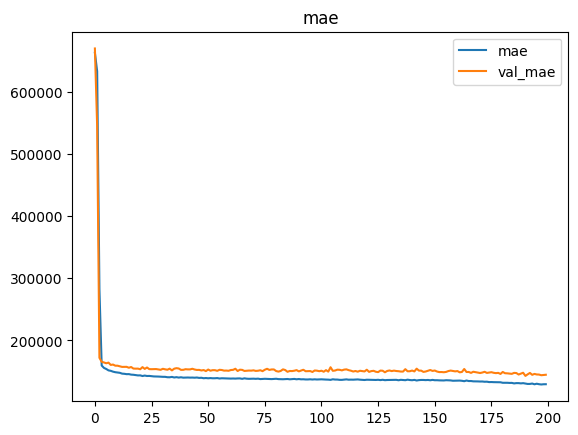

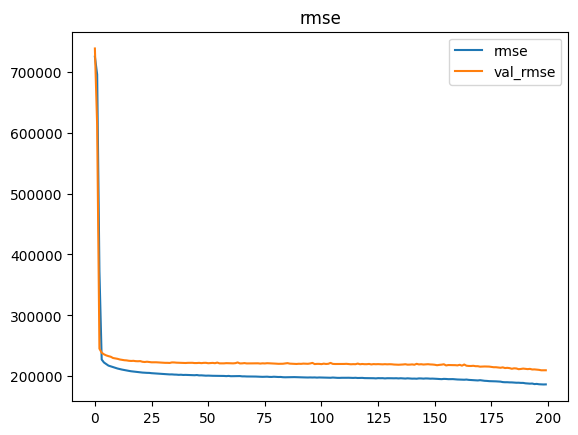

In [43]:
# Apply the custom function to see how your model is doing
plot_history(history)

In [44]:
train_scores = eval_regression(reg_model3,
                         X_train_pca,
                         y_train,
                         name='reg_model3 Train')
test_scores = eval_regression(reg_model3,
                                       X_test_pca,
                                       y_test,
                                       name='reg_model3 test')
scores = pd.concat([scores, train_scores, test_scores])
scores

39/39 [==============================] - 0s 2ms/step


,MAE,RMSE,R2
reg_model1 Train,625379.381101,688753.501128,-4.485105
reg_model1 test,633286.182606,704241.349581,-4.112044
reg_model2 Train,167038.397124,231274.985973,0.381536
reg_model2 test,178440.382884,248537.524259,0.363299
reg_model3 Train,128918.054399,184851.670116,0.604903
reg_model3 test,144886.509357,209814.653271,0.546243
